<a href="https://colab.research.google.com/github/Aman-saimbhi/Deep_Learning_Project1/blob/main/Final_DL_MP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # self.layer5 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = self.layer5(out)
        out = self.dropout(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    # return ResNet(BasicBlock, [2, 2, 2, 2])
    # return ResNet(BasicBlock,[8,8,8,3,1])
    return ResNet(BasicBlock,[1,1,1,1])

In [7]:
from torchvision.transforms.transforms import RandomVerticalFlip
'''Train CIFAR10 with PyTorch.'''
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms

import os
import argparse

print("starting dl project")
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
lr = 0.01

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
best_acc_test= 0
custom_batch_size = 128
total_epochs = 60
optimizer_fn = "sgd"
# optimizer_fn = "adam"

parser.add_argument('--lr', default=lr, type=float, help='learning rate')
parser.add_argument('--device', default='cuda', help='gpu or cpu')
parser.add_argument('--numworkers', default=2,type=int, help='number of workers')
parser.add_argument('--optimizer', default=optimizer_fn,type=str, help='optimizer')

parser.add_argument('--resume', '-r', action='store_true',
                    help='resume from checkpoint')
parser.add_argument('-f')
args = parser.parse_args()
device = args.device

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=custom_batch_size, shuffle=True, num_workers=args.numworkers)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)


testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=args.numworkers)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = project1_model()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()

if args.optimizer == 'sgd':
  optimizer = optim.SGD(net.parameters(), lr=args.lr,momentum=0.9, weight_decay=5e-4)
if args.optimizer == 'nesterov':
  optimizer = optim.SGD(net.parameters(), lr=args.lr, nesterov = True,momentum=0.9, weight_decay = 5e-4)
if args.optimizer == 'adam':
  optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=5e-4)	
if args.optimizer == 'adagrad':
  optimizer = optim.Adagrad(net.parameters(), lr=args.lr,weight_decay=5e-4)
if args.optimizer == 'adadelta':
  optimizer = optim.Adadelta(net.parameters(), lr=args.lr,weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

train_loss_list = []
train_accuracy_list = []
# Training
def train(epoch):
    global best_acc
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    data_time = 0
    train_time = 0
    total_time = 0

    starttot = time.monotonic()
    for batch_idx, (inputs, targets) in enumerate(trainloader):

        start=time.monotonic() 
        inputs, targets = inputs.to(device), targets.to(device)
        end = time.monotonic()

        data_time += (end - start)



        startt = time.monotonic() 
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        endt = time.monotonic()
        
        train_time +=(endt - startt)
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    if acc > best_acc:
          best_acc = acc

    print("Training accuracy in this epoch is: "+ str(acc))

    endtot = time.monotonic()
    total_time +=(endtot - starttot)
    finalLoss = train_loss/len(trainloader)
    train_loss_list.append(finalLoss)
    train_accuracy_list.append(acc)
    #print("Best epoch accuracy is "+ str(best_acc))
    print("Final Train loss is "+ str(finalLoss))
    #print("Time for Training in this epoch " +str(train_time)+" secs")
    #print("Time for data loading in this epoch " +str(data_time)+" secs" )
    
    # Optional
    return total_time

test_loss_list = []
test_accuracy_list = []
def test(epoch):
    global best_acc_test
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc_test:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pt')
        best_acc_test = acc
    finalLoss = test_loss/len(testloader)
    print("Final Test Loss is: " + str(finalLoss))
    test_loss_list.append(finalLoss)
    test_accuracy_list.append(acc)
    #wandb.log({"Test loss": finalLoss,"Accuracy":acc})

    print("test acc is  "+ str(acc))

time_5ep = 0
print(summary(net,(3,32,32)))
print('Learning Rate: ', lr)
for epoch in range(start_epoch, start_epoch+total_epochs):
    time_5ep += train(epoch)
    test(epoch)
    scheduler.step()
#print("Total time for 5 epochs"+str(time_5ep)+" secs")

starting dl project
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12         

In [17]:
for epoch in range(130, 150):
    time_5ep += train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 130
Training accuracy in this epoch is: 100.0
Final Train loss is 0.0032424494511593144
Final Test Loss is: 0.2520365279726684
test acc is  93.21

Epoch: 131
Training accuracy in this epoch is: 99.99
Final Train loss is 0.0032706310787378712
Saving..
Final Test Loss is: 0.24854788903146982
test acc is  93.36

Epoch: 132
Training accuracy in this epoch is: 99.994
Final Train loss is 0.003188614216347313
Final Test Loss is: 0.2507109175994992
test acc is  93.31

Epoch: 133
Training accuracy in this epoch is: 99.992
Final Train loss is 0.003077279448228152
Final Test Loss is: 0.2495068970695138
test acc is  93.23

Epoch: 134
Training accuracy in this epoch is: 99.996
Final Train loss is 0.003091324815381309
Final Test Loss is: 0.25009179167449475
test acc is  93.29

Epoch: 135
Training accuracy in this epoch is: 99.988
Final Train loss is 0.0034124339240557892
Final Test Loss is: 0.24996881306171417
test acc is  93.12

Epoch: 136
Training accuracy in this epoch is: 99.992
Final Tr

In [ ]:
# # Grid Search version
# pip install -U "ray[tune]"

In [ ]:
# import numpy as np
# import os
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import random_split
# import torchvision
# import torchvision.transforms as transforms
# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler

In [ ]:
# def train_cifar(config, checkpoint_dir=None, data_dir=None):

#     net = project1_model()
#     device = "cpu"
#     if torch.cuda.is_available():
#         device = "cuda:0"
#         if torch.cuda.device_count() > 1:
#             net = nn.DataParallel(net)
#     net.to(device)
#     criterion = nn.CrossEntropyLoss()
#     if config["optimizer"] == 'sgd':
#       optimizer = optim.SGD(net.parameters(), lr=config["lr"],momentum=0.9, weight_decay=5e-4)
    
#     if config["optimizer"] == 'adam':
#       optimizer = optim.Adam(net.parameters(), lr=config["lr"], weight_decay=5e-4)	
#     if config["optimizer"] == 'adagrad':
#       optimizer = optim.Adagrad(net.parameters(), lr=config["lr"],weight_decay=5e-4)
    
        
        
#     if checkpoint_dir:
#         model_state, optimizer_state = torch.load(
#             os.path.join(checkpoint_dir, "checkpoint"))
#         net.load_state_dict(model_state)
#         optimizer.load_state_dict(optimizer_state)

#     trainset, testset = load_data(data_dir)

#     test_abs = int(len(trainset) * 0.8)
#     train_subset, val_subset = random_split(
#         trainset, [test_abs, len(trainset) - test_abs])

#     trainloader = torch.utils.data.DataLoader(
#         train_subset,
#         batch_size=int(config["batch_size"]),
#         shuffle=True,
#         num_workers=8)
#     valloader = torch.utils.data.DataLoader(
#         val_subset,
#         batch_size=int(config["batch_size"]),
#         shuffle=True,
#         num_workers=8)

#     for epoch in range(25):  # loop over the dataset multiple times
#         running_loss = 0.0
#         epoch_steps = 0
#         for i, data in enumerate(trainloader, 0):
#             # get the inputs; data is a list of [inputs, labels]
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             # print statistics
#             running_loss += loss.item()
#             epoch_steps += 1
#             if i % 2000 == 1999:  # print every 2000 mini-batches
#                 print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
#                                                 running_loss / epoch_steps))
#                 running_loss = 0.0

#         # Validation loss
#         val_loss = 0.0
#         val_steps = 0
#         total = 0
#         correct = 0
#         for i, data in enumerate(valloader, 0):
#             with torch.no_grad():
#                 inputs, labels = data
#                 inputs, labels = inputs.to(device), labels.to(device)

#                 outputs = net(inputs)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#                 loss = criterion(outputs, labels)
#                 val_loss += loss.cpu().numpy()
#                 val_steps += 1

#         with tune.checkpoint_dir(epoch) as checkpoint_dir:
#             path = os.path.join(checkpoint_dir, "checkpoint")
#             torch.save((net.state_dict(), optimizer.state_dict()), path)

#         tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
#     print("Finished Training")

In [ ]:
# def load_data(data_dir="./data"):
#     transform_train = transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
#         transforms.RandomHorizontalFlip(),
#         #transforms.RandomVerticalFlip(),
#         transforms.ToTensor(),
#         #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#     ])

#     transform_test = transforms.Compose([
#         transforms.ToTensor(),
#         #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#     ])

#     trainset = torchvision.datasets.CIFAR10(
#         root='./data', train=True, download=True, transform=transform_train)
#     trainloader = torch.utils.data.DataLoader(
#         trainset, shuffle=True, num_workers=2)

#     testset = torchvision.datasets.CIFAR10(
#         root='./data', train=False, download=True, transform=transform_test)


#     testloader = torch.utils.data.DataLoader(
#         testset, shuffle=False, num_workers=2)

#     return trainset, testset

In [ ]:
# def test_accuracy(net, device="cpu"):
#     trainset, testset = load_data()

#     testloader = torch.utils.data.DataLoader(
#         testset, batch_size=4, shuffle=False, num_workers=2)

#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in testloader:
#             images, labels = data
#             images, labels = images.to(device), labels.to(device)
#             outputs = net(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     return correct / total

In [ ]:
# def mainfunc(num_samples=10, max_num_epochs=10, gpus_per_trial=1):
#     data_dir = os.path.abspath("./data")
#     config = {
#         "optimizer":tune.choice(["sgd"]),
#         "lr": tune.loguniform(1e-3, 3e-3),
#         "batch_size": tune.choice([128])
#     }
#     print('here')
#     scheduler = ASHAScheduler(
#         metric="loss",
#         mode="min",
#         max_t=max_num_epochs,
#         grace_period=1,
#         reduction_factor=2)
#     reporter = CLIReporter(
#         parameter_columns=["lr", "batch_size","optimizer"],
#         metric_columns=["loss", "accuracy", "training_iteration"])
#     print('here2')

#     result = tune.run(
#         tune.with_parameters(train_cifar, data_dir=data_dir),
#         resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
#         config=config,
#         num_samples=num_samples,
#         scheduler=scheduler,
#         progress_reporter=reporter)
    
#     best_trial = result.get_best_trial("loss", "min", "last")
#     print("Best trial config: {}".format(best_trial.config))
#     print("Best trial final validation loss: {}".format(
#         best_trial.last_result["loss"]))
#     print("Best trial final validation accuracy: {}".format(
#         best_trial.last_result["accuracy"]))

#     best_trained_model = project1_model()
#     device = "cpu"
#     if torch.cuda.is_available():
#         device = "cuda:0"
#         if gpus_per_trial > 1:
#             best_trained_model = nn.DataParallel(best_trained_model)
#     best_trained_model.to(device)

#     best_checkpoint_dir = best_trial.checkpoint.value
#     model_state, optimizer_state = torch.load(os.path.join(
#         best_checkpoint_dir, "checkpoint"))
#     best_trained_model.load_state_dict(model_state)

#     test_acc = test_accuracy(best_trained_model, device)
#     print("Best trial test set accuracy: {}".format(test_acc))

In [ ]:
# mainfunc(num_samples=2, max_num_epochs=25, gpus_per_trial=1)

In [13]:
print(len(train_loss_list))

131


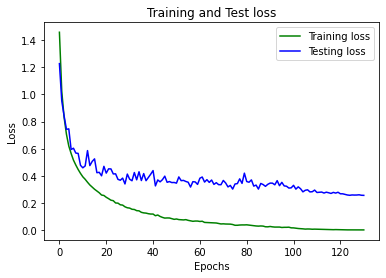

In [15]:
# Plot Training and Validation loss
import matplotlib.pyplot as plt
epochs = range(0,131)
plt.plot(epochs, train_loss_list, 'g', label='Training loss')
plt.plot(epochs, test_loss_list, 'b', label='Testing loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

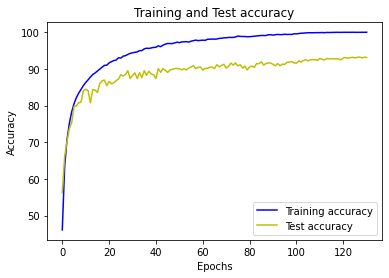

In [16]:
# Plot Training and Testing Accuracy
epochs = range(0,131)
plt.plot(epochs, train_accuracy_list, 'b', label='Training accuracy')
plt.plot(epochs, test_accuracy_list, 'y', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()